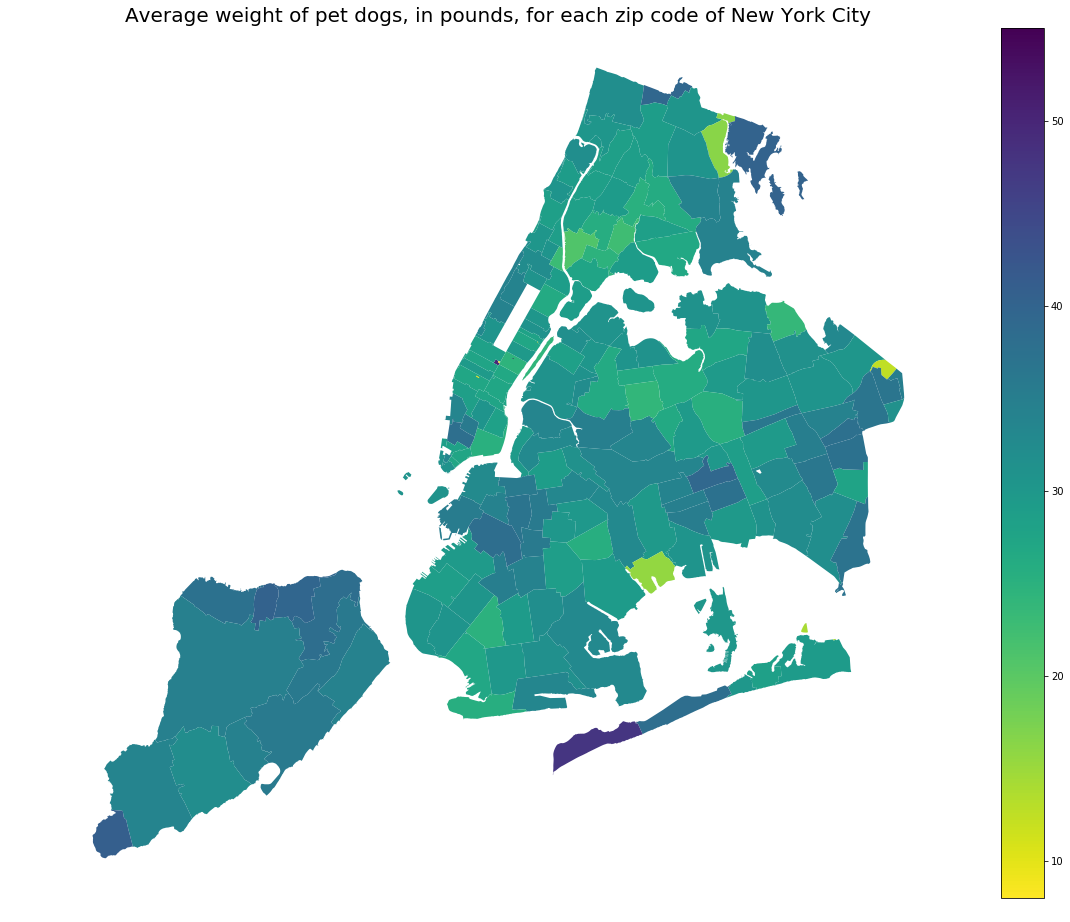

In [105]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import geopandas

### Convert ranges like '7-9 lbs' to 8.0
def range_avg(x):
    if '-' in x:
        s = x.split('-')
        return (int(s[0]) + int(s[1])) / 2
    else:
        return int(x)

### Load the dog weights file into a dataframe
def get_dog_weights():
    # Standardize certain breed names
    breed_map = {'Poodle (Standard)': 'Poodle, Standard', 'Poodle (Toy)': 'Poodle, Toy', 'Poodle (Miniature)': 'Poodle, Miniature', 'Yorkshire Terrier (Yorkie)': 'Yorkshire Terrier', 'German Shepherd Dog': 'German Shepherd', 'Miniature Schnauzer': 'Schnauzer, Miniature', 'Dachshund (Standard)': 'Dachshund, Standard'}
    df = pd.read_csv('dog_weights.csv')
    df['M'] = df['Average Adult Weight (M)'].str.replace('lbs', '').apply(range_avg)
    df['F'] = df['Average Adult Weight (F)'].str.replace('lbs', '').apply(range_avg)
    df.drop(['Average Adult Weight (M)', 'Average Adult Weight (F)'], axis=1, inplace=True)
    df['Breed'].replace(breed_map, inplace=True)
    df = df.melt(value_vars=['M', 'F'], id_vars=['Breed'], value_name='Weight', var_name='Gender')
    return df    

### Load the dog registrations file into a dataframe
def get_dog_registrations():
    boroughs = {'Manhattan', 'Bronx', 'Queens', 'Brooklyn', 'Staten Island'}
    breed_map = {'Bull Dog, French' : 'French Bulldog', 'American Pit Bull Mix / Pit Bull Mix': 'Pitbull', 'American Pit Bull Terrier/Pit Bull': 'Pitbull', 'Poodle': 'Poodle, Standard', 'Dachshund': 'Dachshund, Standard', 'German Shepherd Dog': 'German Shepherd', 'Bull Dog, English': 'Bulldog', 'Welsh Corgi, Cardigan': 'Cardigan Welsh Corgi', 'Welsh Corgi, Pembroke': 'Pembroke Welsh Corgi'}
    df = pd.read_csv('NYC_Dog_Licensing_Dataset.csv')
    # Drop all records not in NYC
    df = df[(df['ZipCode'] > 10000) & (df['ZipCode'] < 11698) & df['Borough'].isin(boroughs)]
    df['ZipCode'] = df['ZipCode'].apply(lambda x: str(x).replace('.0', ''))
    df['BreedName'] = (df['BreedName']
                       .replace(breed_map)
                       .replace(to_replace='\sCrossbreed', value='', regex=True))
    df.replace({'Poodle': 'Poodle, Standard', 'Dachshund': 'Dachshund, Standard'}, inplace=True)
    return df

### Add weight information to dog registration dataframe
dog_weight_df = get_dog_weights()
dog_reg_df = get_dog_registrations()
dogs_df = pd.merge(dog_reg_df, dog_weight_df, left_on=['BreedName', 'AnimalGender'], right_on=['Breed', 'Gender'], how='inner')

### Calculate average dog weight per zip code
nyc = geopandas.read_file(r'./nyc_zip/ZIP_CODE_040114.shp')
weight_by_zip = (pd.DataFrame(dogs_df
                              .groupby('ZipCode')['Weight']
                              .agg('mean'))
                 .reset_index())

### Add weight-per-zip data to NYC shape file
weight_data = pd.merge(nyc, weight_by_zip, right_on='ZipCode', left_on='ZIPCODE', how='inner')

#dogs_df[dogs_df['ZipCode'] == '11239'].groupby('BreedName').agg('count')[['RowNumber']]

f, ax = plt.subplots(1, figsize=(20, 16))
ax = weight_data.plot(ax=ax, column='Weight', cmap='viridis_r', legend=True, vmin=8)
ax.set_axis_off()

plt.title('Average weight of pet dogs, in pounds, for each zip code of New York City', fontsize=20)
plt.show()

In [170]:
from scipy import stats

print("Overall median: {0:.2f}".format(dogs_df['Weight'].median()))
print("Overall mean: {0:.2f}".format(dogs_df['Weight'].mean()))
ues_zips = ['10021', '10028', '10044', '10065', '10075', '10128']
ues_dog_avg = dogs_df[dogs_df['ZipCode'].isin(ues_zips)]['Weight'].mean()
print("UES mean: {0:.2f}".format(ues_dog_avg))
ues_percentile = stats.percentileofscore(dogs_df['Weight'], ues_dog_avg)
print("UES percentile: {0:.2f}".format(ues_percentile))

Overall median: 16.00
Overall average: 30.98
UES average: 29.29
UES percentile: 64.55


(array([2.7609e+04, 2.0096e+04, 3.7780e+03, 7.3700e+03, 1.6790e+03,
        1.3180e+03, 7.1200e+02, 1.6330e+03, 5.4170e+03, 1.1431e+04,
        1.8140e+03, 4.3550e+03, 3.2600e+02, 3.7140e+03, 4.6900e+02,
        1.6000e+01, 2.2400e+02, 5.6400e+02, 4.2000e+01, 2.3000e+01,
        5.9000e+01, 0.0000e+00, 3.4000e+01, 0.0000e+00, 1.0000e+00,
        7.2000e+01, 3.8000e+01, 0.0000e+00, 0.0000e+00, 6.0000e+01]),
 array([  5.        ,  10.91666667,  16.83333333,  22.75      ,
         28.66666667,  34.58333333,  40.5       ,  46.41666667,
         52.33333333,  58.25      ,  64.16666667,  70.08333333,
         76.        ,  81.91666667,  87.83333333,  93.75      ,
         99.66666667, 105.58333333, 111.5       , 117.41666667,
        123.33333333, 129.25      , 135.16666667, 141.08333333,
        147.        , 152.91666667, 158.83333333, 164.75      ,
        170.66666667, 176.58333333, 182.5       ]),
 <a list of 30 Patch objects>)

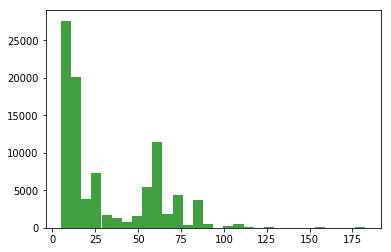

In [165]:
plt.hist(dogs_df['Weight'], 30, facecolor='g', alpha=0.75)